# 01. Import libraries and data

In [2]:
# import libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [5]:
# configure API key
quandl.ApiConfig.api_key = 'cfnEvUAcBknah7d6QDKT'

In [6]:
# import Inflation Rates data "Inflation YOY - Euro Area" variable
data = quandl.get('RATEINF/INFLATION_EUR')

In [7]:
data.head(5)

Value
Date             
1991-01-31   3.90
1991-02-28   4.13
1991-03-31   3.88
1991-04-30   3.85
1991-05-31   4.10

In [8]:
data.shape

(389, 1)

In [9]:
data.columns

Index(['Value'], dtype='object')

In [10]:
type(data)

pandas.core.frame.DataFrame

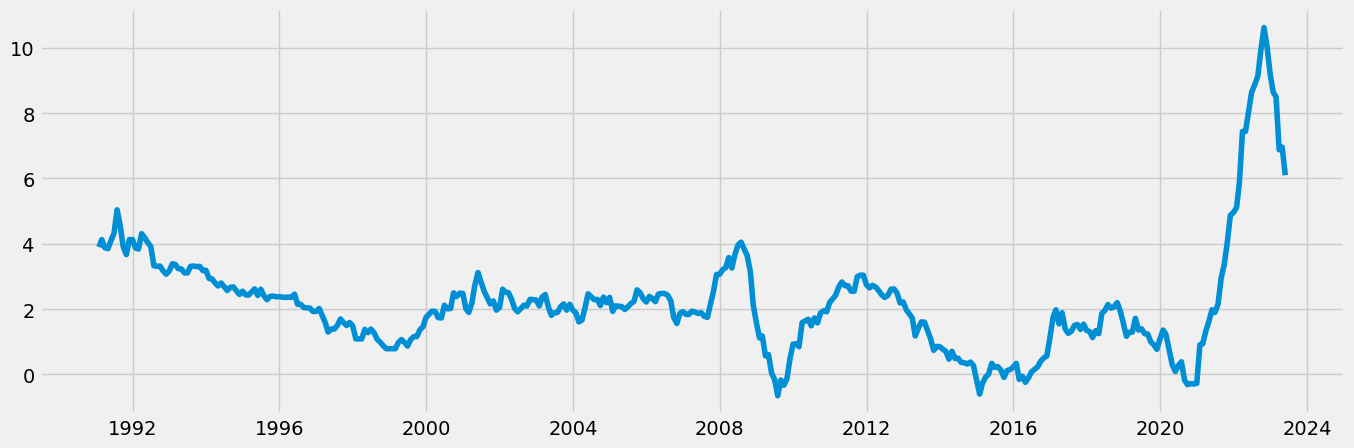

In [11]:
# plot data using matplotlib
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

# 02. Subsetting, wrangling, and cleaning time-series data

In [12]:
# reset index so that data column can be used as filter
data_2 = data.reset_index()

In [13]:
data_2.head()

Date  Value
0 1991-01-31   3.90
1 1991-02-28   4.13
2 1991-03-31   3.88
3 1991-04-30   3.85
4 1991-05-31   4.10

In [19]:
data_sub = data_2.loc[(data_2['Date'] >= '2010-01-01') & (data_2['Date'] < '2023-07-08')]

In [20]:
data_sub.shape

(161, 2)

In [21]:
data_sub.head()

Date  Value
228 2010-01-31   0.94
229 2010-02-28   0.85
230 2010-03-31   1.59
231 2010-04-30   1.64
232 2010-05-31   1.69

In [22]:
# set data column as index
from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date'])
data_sub = data_sub.set_index('datetime')
data_sub.drop(['Date'], axis=1, inplace=True)
data_sub.head()

Value
datetime         
2010-01-31   0.94
2010-02-28   0.85
2010-03-31   1.59
2010-04-30   1.64
2010-05-31   1.69

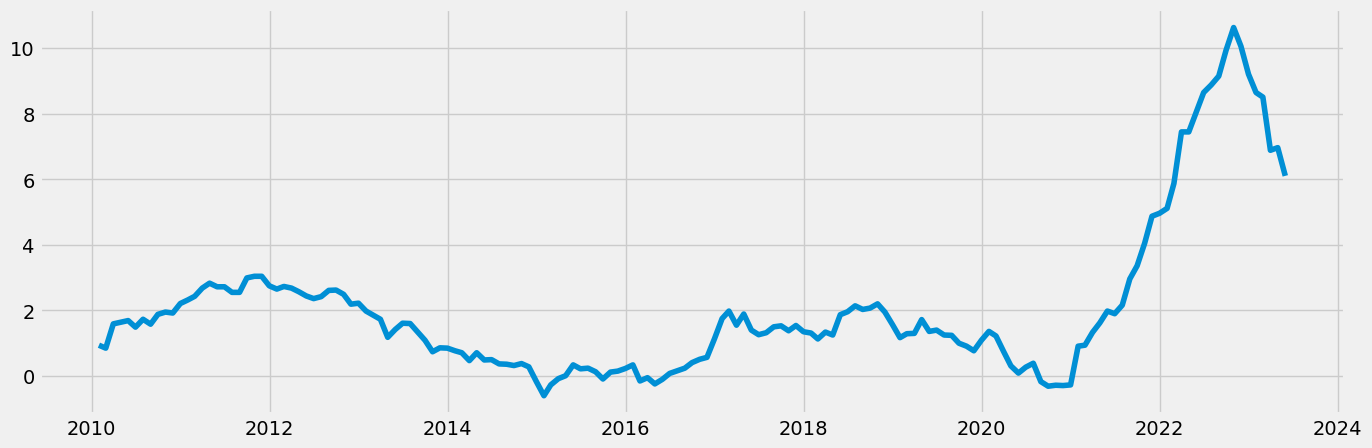

In [23]:
# plot new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [29]:
# check missing values
data_sub.isnull().sum()

Value    0
dtype: int64

# 03. Time-series analysis : decomposition

In [30]:
# decompose the time series using additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [31]:
from pylab import rcParams #define fixed size for special charts

rcParams['figure.figsize'] = 18,7

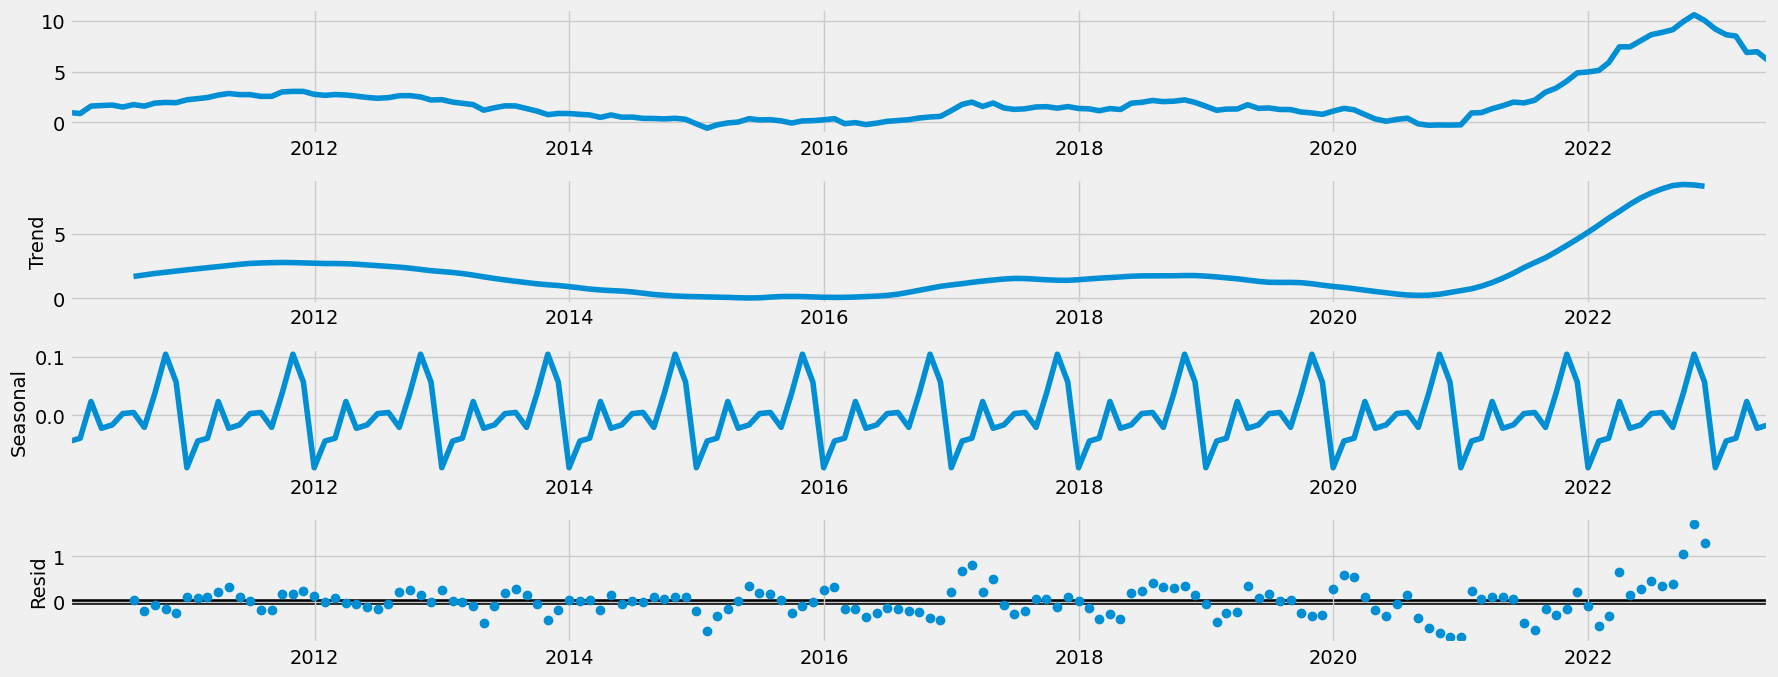

In [32]:
# plot the separate components
decomposition.plot()
plt.show()

When looking over the above chart, there are a few things to take note of. First is the trend. You can see that inflation rates have only had minor fluctuations over the years until about 2021, when inflation rates increased greatly. This we know was most likely due to the Corona Virus pandemic. 
Seasonality is another section on the plot to take note of. In the above plot you can see that seasonality fluctuations of inflation rates occur at a fixed interval. In each year there is a consistent spike and then a drop.
The last plot point is residual. This is what's left of the data after the trend and seasonality have been extracted. You can see that in the inflation rates data there isn't much unexplained noise. 

# 04. Testing for stationarity

In [33]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.716593
p-value                          0.071211
Number of Lags Used             12.000000
Number of Observations Used    148.000000
Critical Value (1%)             -3.475325
Critical Value (5%)             -2.881275
Critical Value (10%)            -2.577293
dtype: float64


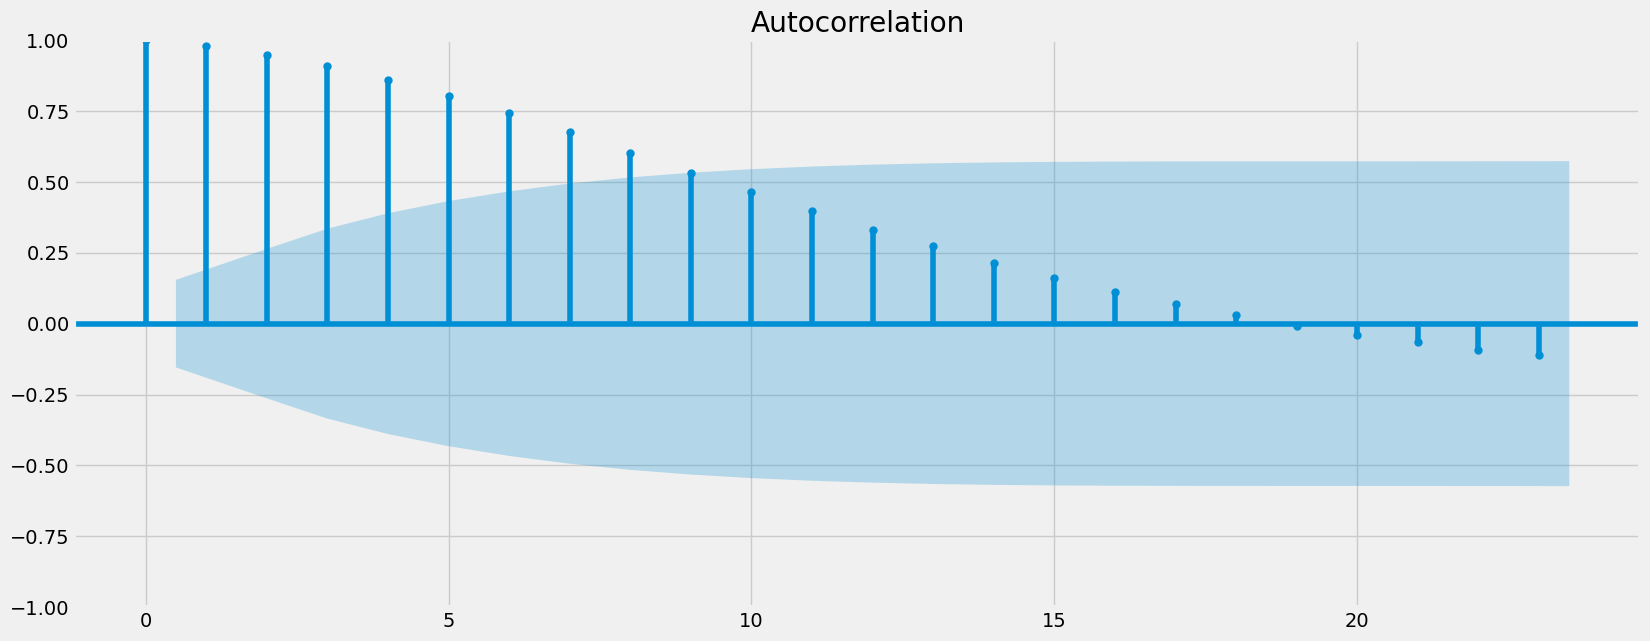

In [34]:
# check plot for autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_sub)
plt.show()

The Critical Value (5%) in the above data has a value of -2.881275. This is smaller than the test statistic, which is -2.716593. Therefore, we cannot reject the null hypothesis becuase there is a unit root in the data and our data is non-stationary.
We also need to look at the autocorrelation data to further determine the stationarity. When looking at the above plot, you can see there are lines that go above the blue edge of the confidence interval. This means there are lags that are significantly correlated to each other. This also means that the data is non-stationary. 

# 05. Stationarizing inflation rates data

In [35]:
data_diff = data_sub - data_sub.shift(1)

In [36]:
data_diff.dropna(inplace = True)

In [37]:
data_diff.head()

Value
datetime         
2010-02-28  -0.09
2010-03-31   0.74
2010-04-30   0.05
2010-05-31   0.05
2010-06-30  -0.20

In [38]:
data_diff.columns

Index(['Value'], dtype='object')

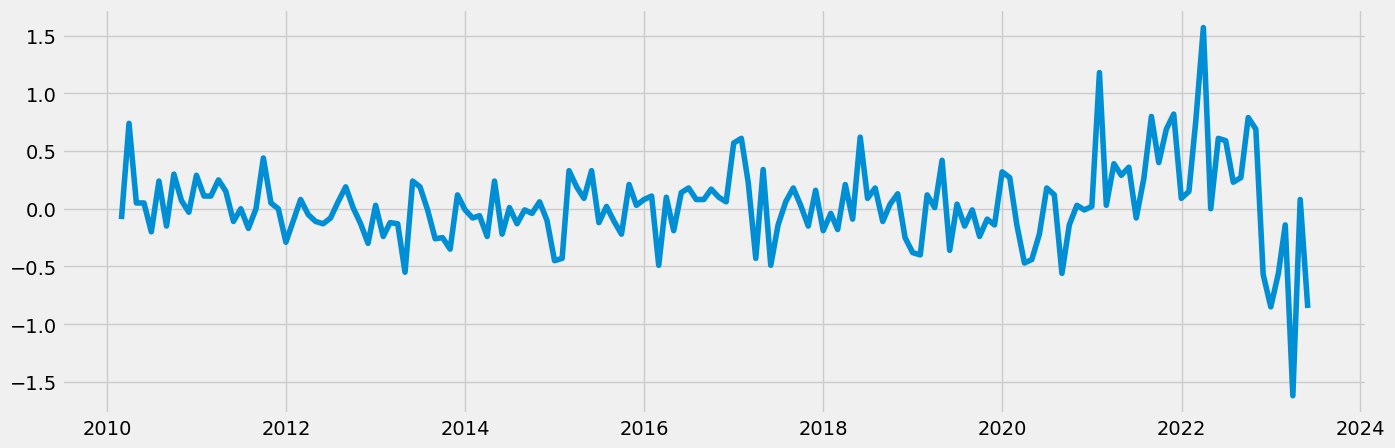

In [39]:
# check what differencing did to time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [40]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.549866
p-value                          0.006795
Number of Lags Used             11.000000
Number of Observations Used    148.000000
Critical Value (1%)             -3.475325
Critical Value (5%)             -2.881275
Critical Value (10%)            -2.577293
dtype: float64


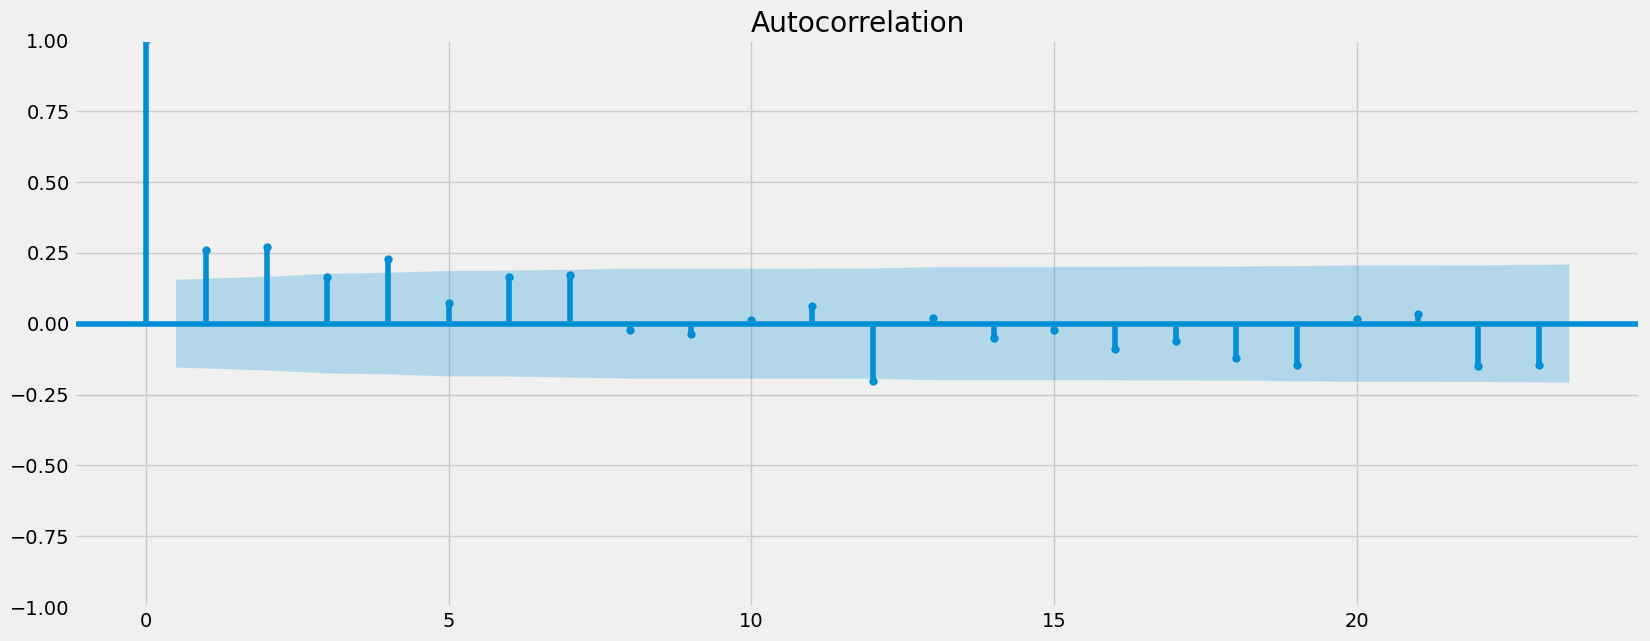

In [41]:
plot_acf(data_diff)
plt.show()